# The Project <a class="anchor" id="t1"></a>

One year ago we embark on a new project in Mad Flow. It continues the roadmap of the company to improve the quality of life in Madrid. The objective was to forecast the traffic in the city and to show it in an interface in real time so that citizens can better plan their route. Traffic analysis has become an indispensable task in smart cities. Having a better knowledge of the traffic allows a better organization and governance of the roads. 

In addition, we studied the possibility of including other data such as precipitation or temperature  for better predictions. The data provided by sensors in smart cities are usually heterogeneous. In the case of the city of Madrid in Spain, there are climatic and traffic data that cover the entire center of the city.

Testing the model we found an important performance limitation. The infrastructure was slow and unwieldy when incorporating new traffic data-sets or building new insights quickly what is essential in the project. To move forward with the project, a change in implementation was necessary.

We found a solution to our problem: Kdb+/q by KX. This platform is extremely fast and flexible and allows data processing in real time. It also has PyKX, an open-source library that is designed to be friendly with Python programmers (essential in Mad Cool).

In this technical report we present how the migration of the code to the KX platforms was carried out. But first we'll talk about the use case and the code we already have.

<div class="alert alert-block alert-info">
<b> 🔍 You can find <a href="https://github.com/hablapps/AllRoadsLeadToPyKX/blob/Python-Version-Pre/AllRoadsLeadToPyKX.md">Original Python Project</a> in Github. 
</div>

**Index**

[**The project**](#t1)   
  [**The Use Case**](#t11)   
  [**The Data**](#t12)   
  [**The Cleaning**](#t13)   
  [**The Final Table**](#t14)   
  [**The Interpretation**](#t15)   
[**PyKX migration:** ](#ID2)   
  [**PyKX saving the day!**](#t12)   
  [**Datasets**](#t13)   
  [**Model**](#t14)   
[**Q Migration:**](#ID2)   
  [**Qholic**](#t12)   
  [**Datasets**](#t13)   
  [**Model**](#t14)    


## The Use Case

The objective of the code is to prepare and join the traffic and weather data to be ingested by an LSTM model.

Although this project is novel in the city of Madrid, there are many articles that support it. For example, [F. Malik et al.](https://www.mdpi.com/1424-8220/20/13/3749) forecasted traffic in Madrid based on air pollution through a model based on LSTM.

On the dependence of the weather on traffic there are many studies, especially focused on rainfall. None of the studies are carried out in Madrid, but in several large cities such as Manchester ([A. Essien et al.](https://pure.manchester.ac.uk/ws/portalfiles/portal/72721911/DEXA_Camera_8_pages.pdf)), Shenzhen ([Y. Yao et al.](https://ieeexplore.ieee.org/document/8964560)), Belgrade ([M. Vidas et al.](https://www.safetylit.org/citations/index.php?fuseaction=citations.viewdetails&citationIds[]=citjournalarticle_716898_14)). The results of these studies predict a 5-15% increase in traffic volume on weekdays during peak hours.

## The Data

Madrid weather and traffic data are offered by the [Madrid City Council](https://datos.madrid.es/portal/site/egob). These datasets include live and historical records. For model ingestion we only need the historical data. This data, which is in csv format, is divided into months from the year 2018 to the present.

**Weather**

[Weather data](https://datos.madrid.es/portal/site/egob/menuitem.3efdb29b813ad8241e830cc2a8a409a0/?vgnextoid=4950cc720ba29610VgnVCM2000001f4a900aRCRD&vgnextchannel=102612b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)  is captured by stations located throughout the city of Madrid. It looks like the following table:

|    |   weather_station |   magnitud |   year |   month |   day |    H01 | V01   | ...|
|---:|------------------:|-----------:|-------:|--------:|------:|-------:|------:|:------|
|  0 |               108 |         81 |   2022 |      12 |    22 |  270   | N     | ...|
|  1 |               108 |         82 |   2022 |      12 |    22 |    9   | N     |...|
|  2 |               108 |         83 |   2022 |      12 |    22 |   94.7 | N     |...|
|  3 |               108 |         86 |   2022 |      12 |    22 | 1031   | N     |...|
|  4 |               108 |         87 |   2022 |      12 |    22 |    2   | N     |...|


In the documentation they tell us that the magnitude column indicates what type of meteorological data has been taken in the row:

    · 80: ultraviolet
    · 81: wind
    · 82: direction
    · 83: temperature
    · 86: humidity
    · 87: pressure
    · 88: solar
    · 89: rainfall
    
Then we have two columns for each hour so that the first tells us the value for the data type specified by the magnitude column and if the result is valid or not. We also have columns related to the time in which the measurement is taken. Finally, there is the identifier of the meteorological station which we can connect with its coordinates using this other [table](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=2ac5be53b4d2b610VgnVCM2000001f4a900aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default) provided by the Madrid city council:

|    |   weather_station |   Longitude |   Latitude |
|---:|------------------:|------------:|-----------:|
|  0 |                 4 |    -3.71226 |    40.4239 |
|  1 |                 8 |    -3.68232 |    40.4216 |
|  2 |                16 |    -3.63924 |    40.44   |
|  3 |                18 |    -3.73184 |    40.3948 |
|  4 |                24 |    -3.74734 |    40.4194 |

**Traffic**

Traffic sensors are located at traffic lights in the city of Madrid. The data obtained is made up of several measurements of the road situation such as speed or traffic volume. All of these metrics are coded into the "load" metric (a percentage that measures congestion). The [traffic table](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=02f2c23866b93410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD) head is:

|    |   traffic_station | tipo_elem   |   intensidad |   ocupacion |   load |   vmed | error   |   periodo_integracion | date                |
|---:|------------------:|:------------|-------------:|------------:|-------:|-------:|:--------|----------------------:|:--------------------|
|  0 |              1001 | M30         |         3240 |           9 |      0 |     59 | N       |                     5 | 2022-12-01 00:00:00 |
|  1 |              1001 | M30         |         3240 |           9 |      0 |     59 | N       |                     5 | 2022-12-01 00:15:00 |
|  2 |              1001 | M30         |          300 |           1 |      0 |     66 | N       |                     5 | 2022-12-01 00:30:00 |


The table also contains a column for the date and another that identifies the sensor that will be used to link it with its coordinates using the following [table](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=ee941ce6ba6d3410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD):

|    | "tipo_elem"   |   "distrito" |   "id" | "cod_cent"   | "nombre"                                                          |   "utm_x" |     "utm_y" |   Longitude |   Latitude |
|---:|:--------------|-------------:|-------:|:-------------|:------------------------------------------------------------------|----------:|------------:|------------:|-----------:|
|  0 | "URB"         |            4 |   3840 | "01001"      | "Jose Ortega y Gasset E-O - Pº Castellana-Serrano"                |    441615 | 4.47577e+06 |    -3.68832 |    40.4305 |
|  1 | "URB"         |            4 |   3841 | "01002"      | "Jose Ortega y Gasset O-E - Serrano-Pº Castellana"                |    441706 | 4.47577e+06 |    -3.68726 |    40.4305 |
|  2 | "URB"         |            1 |   3842 | "01003"      | "Pº Recoletos N-S - Almirante-Prim"                               |    441319 | 4.47484e+06 |    -3.69173 |    40.4221 |

## The Cleaning

Once the data has been loaded, we prepared the data to be used in the analysis and the model. As we are dealing with heterogeneous datasets, the cleaning of the data will be done independently and the data will be assembled a single table later.

#### Weather

1. In the weather dataset we have the date separated into day, month and year, but in traffic all these data are together. This is why the columns have been grouped into a date column of shape: ```day-month-year```. 

2. We also transform each hour value measurement and its validity into independent rows and we take the opportunity to remove invalid measurements:

|       | hour            |   value |
|------:|:----------------|--------:|
|     0 | 0 days 00:00:00 |    7.1  |
|     1 | 0 days 00:00:00 |    6.8  |
|     2 | 0 days 00:00:00 |    2.8  |
|     3 | 0 days 00:00:00 |    5.6  |

3. To homogenize the time measure with the traffic table we join the date with the time. The new date shape is ```date-month-year hour:minute:second```

4. Finally, to have more organized data, we convert the different types of measurement into columns:

|      | date                |   weather_station |   direction |   humidity |   pressure |   rainfall |   solar |   temperature |   wind |
|-----:|:--------------------|------------------:|------------:|-----------:|-----------:|-----------:|--------:|--------------:|-------:|
|    0 | 2022-12-01 00:00:00 |                 4 |           0 |          0 |          0 |        0   |       0 |           7.1 |   0    |
|    1 | 2022-12-01 00:00:00 |                 8 |           0 |         67 |          0 |        0   |       0 |           9.4 |   0    |
|    2 | 2022-12-01 00:00:00 |                16 |           0 |         73 |          0 |        0   |       0 |           8.9 |   0    |

#### Traffic

1. The rows where the data collection has had an error are eliminated, for this we filter the values without measurement errors. In the documentation they tell us that these values are represented with an "N". 

2. We only keep the load measurement, which is what we are interested in for the analysis.

3. Since the measurements of the sensors are taken every 15 minutes, we group the values for each hour and calculate the average so that it matches the weather table:

|    | date                |   traffic_station |   load |
|---:|:--------------------|------------------:|-------:|
|  0 | 2022-12-01 00:00:00 |              1001 |      0 |
|  1 | 2022-12-01 00:00:00 |              1002 |      0 |
|  2 | 2022-12-01 00:00:00 |              1003 |      0 |
|  3 | 2022-12-01 00:00:00 |              1006 |      0 |
|  4 | 2022-12-01 00:00:00 |              1009 |      0 |

The average time for loading and processing a month of traffic information is **43.9 s**. The team is concerned about the slowness and the possible effect it will have on real-time data processing.

**Location**

To join the two previous tables we need to know which traffic sensors correspond to the weather stations. To do this you can use a distance matrix and find the closest pairs. You could measure this distance directly with the coordinates. But to make the distances clearer, the Haversine distance was used, which calculates the distance in meters between a pair of coordinates. It can be seen in the next heatmap that these distances are between 0 and 20 km:

<figure>
<img src="files/image_source/heatmap3.png">
<figcaption style = "text-align: center"> <b>Figure 1:</b> Heatmap of distances in km between weather and traffic stations </figcaption>
</figure>


## The Final Table <a class="anchor" id="t14"></a>

Once we have prepared the 3 tables -weather, traffic and distance- we put them together. And, finally, we can add the information of the time and the day of the week to study its dependence on the traffic load.

|    | date                |   traffic_station |   load |   Distance |   Closest |   weather_station |   direction |   humidity |   pressure |   rainfall |   solar |   temperature |   wind |   weekday |   hour |
|---:|:--------------------|------------------:|-------:|-----------:|----------:|------------------:|------------:|-----------:|-----------:|-----------:|--------:|--------------:|-------:|----------:|-------:|
|  0 | 2022-12-01 00:00:00 |              1001 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  1 | 2022-12-01 00:00:00 |              1002 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  2 | 2022-12-01 00:00:00 |              1003 |      0 |         14 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  3 | 2022-12-01 00:00:00 |              1006 |      0 |         15 |         1 |                 8 |           0 |         67 |          0 |          0 |       0 |           9.4 |      0 |         3 |      0 |
|  4 | 2022-12-01 00:00:00 |              1009 |      0 |         14 |         0 |                 4 |           0 |          0 |          0 |          0 |       0 |           7.1 |      0 |         3 |      0 |

## Data interpretation

Several studies were carried out to find out what time variables could be interesting to add to the model. In the first place, since traffic is so dependent on time, the measurements will be filtered to obtain the days of the week and the hours where there is usually more traffic. This will make it easier for the test model to learn. School days tend to have more traffic than holidays. Just as there is usually more traffic during the day than at night. In the following figure we can verify that the data have a strong seasonality:

<table>
    <tr>
    <td style='text-align:center;'>
<figure>
<img src="files/image_source/loadperhour.png">
<figcaption style = "text-align: center">   <b>Figure 2:</b> Load per Hour </figcaption>
</figure>
 </td>
    <td>
<figure>
<img src="files/image_source/loadperweekday.png">
<figcaption style = "text-align: center">   <b>Figure 3:</b> Load per Weekday </figcaption>
</figure>
            </td>
    </tr>
</table>

We keep the data between 10 a.m. and 8 p.m., from Monday to Friday, for the rest of the project.

Regarding the Rainfall-Load dependency ee started seeing that rainy days are very few:

|       |       rainfall |
|:------|---------------:|
| count | 841068         |
| mean  |      0.0130932 |
| std   |      0.194232  |
| min   |      0         |
| 50%   |      0         |
| 90%   |      0         |
| 99.9% |      2.9       |
| max   |     10.9       |

We can see in the percentiles of the precipitation column that there are very few recordings with rain. This is why the measurements were divided into different classes depending on the level of rain and we did a separate analysis for the data with heavy rain, moderate to moderate and no rain. The analysis was done hourly to avoid the temporal dependence of the load. We can verify this in the following table, where the average increase in hours of traffic congestion with rain can go from 5% to 14%, which agrees with the studies presented in [Some Reading](#t12).

<figure>
<img src="files/image_source/rainfall.png">
<figcaption style = "text-align: center"> <b>Figure 4:</b> The average traffic load per hour for the measurements with heavy rain (blue), moderate rain (brown) and no rain (green).</figcaption>
</figure>

To verify that these differences between groups are significant, we can do an anova test. And we see that in all hours there is great evidence that the load is different between the different types of rain. For example, for hour 12:

|             |          sum_sq |    df |        F |       PR(>F) |
|:------------|----------------:|------:|---------:|-------------:|
| C(rainfall) | 37650.7         |     6 |  20.1144 |   1.3346e-23 |
| Residual    |     8.01363e+06 | 25687 | nan      | nan          |

It was decided to include precipitation within the model. The rest of the meteorological conditions did not give such a clear result, so they will be left out.

## Month 6:  Playing with the Model

To check the performance we created a toy model using a simple LSTM with 5 steps back to forecast the load at a single station. The input includes only the 5 steps prior to the prediction of the load, the rain, the time and the day of the week. The results for a single station seem quite positive as can be seen in [Graph 6](#Image61). But the temporary cost for a single station and a single month is unaffordable for the project budget. Also, the pre-processing takes too long for the final application in real time.

<table> <a class="anchor" id="Image61"></a>
    <tr>
    <td style='text-align:center;'>
<figure>
<img src="files/image_source/loss_python.png">
<figcaption style = "text-align: center">   <b>Figure 5:</b> Train vs Test loss plot  </figcaption>
</figure>
 </td>
    <td>
<figure>
<img src="files/image_source/test_python.png">
<figcaption style = "text-align: center">   <b>Figure 6:</b> Traffic Forecasting for a traffic station </figcaption>
</figure>
            </td>
    </tr>
</table>


# PyKX migration

RESUMEN DEL CAPITULO

## Learning PyKX 

Before starting the project, the Mad Flow team received training from Habla Computing on q and PyKX. After this introduction to KX platforms, some of the developers fell in love with q, while others felt more comfortable in the Python ecosystem. PyKX is designed so that these two profiles coexist in the same development environment. The team has made a compilation of perspectives, some more pythonic and others more qtonic, with which they feel more comfortable programming:

* **NOMBRE GUAY 1:  [Useful Read/Write Functions](https://code.kx.com/pykx/1.6/api/read.html)**

>*"PyKX offers several functions that help loading and writing data, they are very versatile and the parameters are very intuitive."*

In [65]:
import pykx as kx
traffic_station = kx.q.read.csv('./pmed_ubicacion_12-2022.csv', types = "SII**FFFF", delimiter = ";", as_table=True)

* **NOMBRE GUAY 2: [Use pythonic indexing](https://code.kx.com/pykx/1.6/user-guide/fundamentals/indexing.html)**

> *"Accessing data from q objects such as lists or tables from python can be done with indexing similar to what you can use in numpy or pandas. This has made my job much easier."*

In [50]:
elem = traffic_station["tipo_elem"]
lat = traffic_station["latitud"]
print(lat[:5])

40.4305 40.43052 40.42213 40.42143 40.43378


* **NOMBRE GUAY 3: [Use q functions]()**

> *"For those like me who want to delve into the q language and gain experience, you can use language functions, ...*

In [76]:
distinct = kx.q("distinct", elem) # unique values in the list
print(distinct) 

`URB`other`M30


> *iterate over them*

In [77]:
print(kx.q("lower").each(distinct)) # lower case unique values of the list

`urb`other`m30


>*or even create them, and use them with pykx objects."*

In [68]:
print(kx.q("{u !(sum x=) each u:distinct x}", elem)) # Count the occurrences of distinct values

URB  | 4266
other| 128
M30  | 296


* **NOMBRE GUAY 4: Use [Numpy](https://code.kx.com/pykx/1.6/user-guide/advanced/numpy.html) and  [Pandas](https://code.kx.com/pykx/1.6/user-guide/advanced/Pandas_API.html)**

> *"Those of us who are not yet so familiar with the ecosystem that we can continue using part of the functionality of Numpy...*

In [24]:
import numpy as np
np.mean(lat)

40.42870774510621

>*"... and from pandas via the Pandas API.*

In [64]:
import os
os.environ['PYKX_ENABLE_PANDAS_API'] = 'true'
import pykx as kx
import numpy as np
import pandas as pd

print(traffic_station[traffic_station["tipo_elem"]=="other"][:5]) # filter rows where the values of a column meet a condition

tipo_elem distrito id   cod_cent nombre                                      ..
-----------------------------------------------------------------------------..
URB       4        3840 "01001"  "Jose Ortega y Gasset E-O - P\302\272 Castel..
URB       4        3840 "01001"  "Jose Ortega y Gasset E-O - P\302\272 Castel..
URB       4        3840 "01001"  "Jose Ortega y Gasset E-O - P\302\272 Castel..
URB       4        3840 "01001"  "Jose Ortega y Gasset E-O - P\302\272 Castel..
URB       4        3840 "01001"  "Jose Ortega y Gasset E-O - P\302\272 Castel..



<div class="alert alert-block alert-info">
<b>To use it we only have to import numpy and pandas and activate a flag. Pandas API is still in the development phase, so it does not yet have all the functions of Pandas. More information in <a href="https://code.kx.com/pykx/1.6/user-guide/advanced/Pandas_API.html"> Pandas API </a> . 
</div>
    
    


* **NOMBRE GUAY 5: Use [qSQL querys](https://code.kx.com/pykx/1.6/api/query.html)**

> *"SQL queries are very powerful and concise at the same time. PyKX allows you to query PyKX objects as well as API functions...* 

In [83]:
print(kx.q.qsql.select(traffic_station, {"name":"5 # nombre"}, where="tipo_elem = `other")) # filter rows where the values of a column meet a condition

name        
------------
"03FL08PM01"
"03FL08PM02"
"03FL20PM01"
"03FL56PM01"
"03FT08PM01"


> *...or using our own functions q."*

In [82]:
print(kx.q("{select name:5#nombre from x where tipo_elem = `other}", traffic_station)) # filter rows where the values of a column meet a condition

name        
------------
"03FL08PM01"
"03FL08PM02"
"03FL20PM01"
"03FL56PM01"
"03FT08PM01"


* **NOMBRE GUAY 6: Use [SQL querys](https://code.kx.com/pykx/1.6/api/query.html)**

>*"Whoa! PyKx lets you use SQL queries too!"*

In [ ]:
kx.q.sql("select top 5 nombre from $1 where tipo_elem=`other", traffic_station)

* **6. Contexto Q**

> *"I'm more comfortable programming in q, so I work in the context of q. PYKX objects can be passed into the q context and work with them as if you were in a q ecosystem:"*

In [81]:
kx.q["traffic_station"] = traffic_station # Move Pykx Object to Q Context

print(kx.q("select name:5#nombre from traffic_station where tipo_elem = `other")) # Working with the table inside q

name        
------------
"03FL08PM01"
"03FL08PM02"
"03FL20PM01"
"03FL56PM01"
"03FT08PM01"


During the development of the project some of these methods are used. The best thing is that they are fully compatible with each other, so developers can choose the one that is most comfortable for them!

## Load Data

In [196]:
weather = kx.q('.Q.id("  II ***",(24*2)#"FS";enlist ";")0:`$":./dic_meteo22.csv"')
weather_station = kx.q.read.csv('./Estaciones_control_datos_meteorologicos.csv', types=" IFF", delimiter=";", as_table=True)
traffic = kx.q.read.csv('./12-2022.csv', types = "IPSIIIISI", delimiter = ";", as_table = True)
traffic_station = kx.q.read.csv('./pmed_ubicacion_12-2022.csv', types = "SII**FFFF", delimiter = ";", as_table=True)

## Cleaning Datasets

#### Weather

In [199]:
weather = kx.q.xcol({'ANO': 'year', 'MES': 'month', 'DIA': 'day', 'ESTACION':'weather_station', 'MAGNITUD':'magnitude'}, weather)
weather = kx.q.qsql.update(weather, columns = {'date': '"D"$(raze\')flip(year;month;day)'})
weather = kx.q.qsql.delete(weather, ['year', 'month', 'day', 'PUNTO_MUESTREO', 'PROVINCIA', 'MUNICIPIO'])

In [200]:
cols = kx.q.cols(weather)
def xexpr(pattern):
  xcols = cols[kx.q.where(kx.q.like(cols, pattern))]
  xsel = kx.q.sv(b";", kx.q.string(xcols)).py().decode("utf-8")
  return (xcols, 'flip(' + xsel + ')')

hour = 'count[i]#enlist 01:00*til 24'
(hcols, value) = xexpr(b'H*')
(vcols, valid) = xexpr(b'V*')

In [201]:
weather = kx.q.qsql.update(weather, columns = {'hour': hour, 'values': value, 'valid': valid})
weather = kx.q.qsql.update(weather, columns = {'date': 'date+hour'})
weather = kx.q.qsql.delete(weather, columns = kx.q.raze(hcols,vcols).py() + ["hour"])
weather = kx.q.ungroup(weather)
weather = kx.q('_', kx.q('1#`VALID'), kx.q.qsql.select(weather, where = 'valid=`V'))

In [202]:
magnitude = {80:"ultraviolet", 
             81:"wind", 
             82:"direction", 
             83:"temperature", 
             86:"humidity", 
             87:"pressure", 
             88:"solar", 
             89:"rainfall"}

weather = kx.q('{update magnitude: x magnitude from y}', magnitude, weather)
weather = kx.q('{exec (value x)#magnitude!values by date,weather_station from y}', magnitude, weather)

#### Traffic

In [209]:
traffic = kx.q.xasc("date", kx.q.qsql.select(traffic,
                         columns = {'traffic_load': 'avg carga'},
                         by = {"traffic_station": 'id', "date":'0D01:00:00 xbar fecha'}, 
                         where = "error=`N"))

**Location**

In [204]:
weather_station = kx.q.xcol({'CODIGO_CORTO' : 'weather_station', "LONGITUD":"longitude", "LATITUD":"latitude"}, weather_station)

In [205]:
traffic_station = kx.q.xcol({'id' : 'traffic_station', "longitud":"longitude", "latitud":"latitude"}, traffic_station)

In [206]:
from haversine import haversine_vector, Unit
dist = kx.toq(
            haversine_vector(kx.q('`longitude`latitude#', weather_station).pd(), 
                             kx.q('`longitude`latitude#', traffic_station).pd(),
                             Unit.KILOMETERS, comb=True))

In [207]:
ids = kx.q.each(kx.q('{first where x=min x}'), dist)
distance_table = kx.q('^', traffic_station, weather_station[ids])
distance_table = kx.q.qsql.delete(distance_table, columns = ['tipo_elem','distrito','cod_cent','nombre','utm_x','utm_y','longitude', 'latitude'])

### Join Table

In [210]:
complete = kx.q.lj(traffic, kx.q.xkey('traffic_station', distance_table))
complete = kx.q.aj(kx.q('`weather_station`date'), complete, weather)
complete = kx.q.qsql.update(complete,  {"hour":"`hh$date", "weekday":'("d"$date)mod 7'})

### Modelo

In [235]:
kx.q("minMaxScale:{[l] ({(x-y)%(z-y)}[;min l;max l]')l}")

final = kx.q.qsql.select(complete, columns = {"date": "date",
                                              "traffic_station":"traffic_station",
                                              "hour":"hour", 
                                              "weekday": "weekday", 
                                              "traffic_load": "minMaxScale traffic_load%100", 
                                              "temperature":"minMaxScale temperature", 
                                              "rainfall":"minMaxScale rainfall"},
                                    where = [
                                        "weekday>1",
                                        "9<hour",
                                        "hour<20",
                                        "40 <= (avg; traffic_load) fby traffic_station"
                                    ])


kx.q("""sw:{({y#z _x}[x;y;]')til count b:y _x}""") # sliding window function. takes matrix and divides into chunks of 5x5
kx.q("""gl:{y _(flip x)[z]}""") # gets target (in position z)
kx.q("""toMatrix:{({[t;i]value t[i]}[x;]')til count x:flip x}""") # / table to matrix

kx.q("""
        prepareData:{[data; test_per_series; lb]
            m:`rainfall`traffic_load`hour`weekday;        
            train:(toMatrix')?[data;();`traffic_station;m!({(y;(+;(count;x);80);x)}[;#]')m]; 
            test:(toMatrix')?[data;();`traffic_station;m!({(y;(-;(count;x);80);x)}[;#]')m];                                                                               
            (((sw[;lb]')test;(gl[;lb;1]')test);((sw[;lb]')train;(gl[;lb;1]')train))                                                  
            }                                                
        train: 
        }
    """)

data = kx.q("prepareData", final, 80, 5)

X_train, y_train = data[0][0], data[0][1]
X_test, y_test =  data[1][0], data[1][1]

QError: series

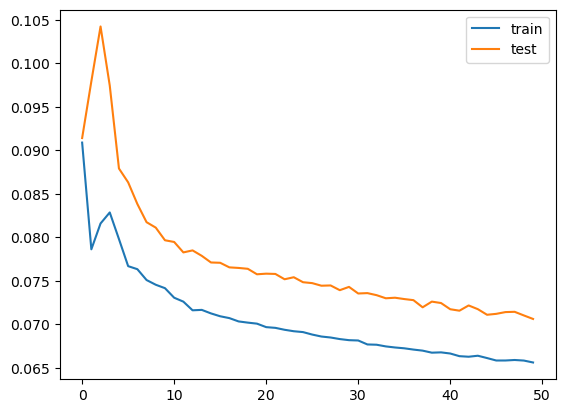

In [229]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Conv1D
from keras.layers import BatchNormalization

import matplotlib.pyplot as plt
# design network
model = Sequential()

#model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None,1]))
model.add(LSTM(units = 50, return_sequences=True, input_shape=[None,5]))
model.add(Dense(units = 1))

model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(np.array(train[0][3403].py()), np.array(train[1][3403].py()), epochs=50, batch_size=8, validation_data=(np.array(test[0][3403].py()), np.array(test[1][3403].py())), verbose=0, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.legend()
plt.show()

3/3 [==============================] - 2s 19ms/step


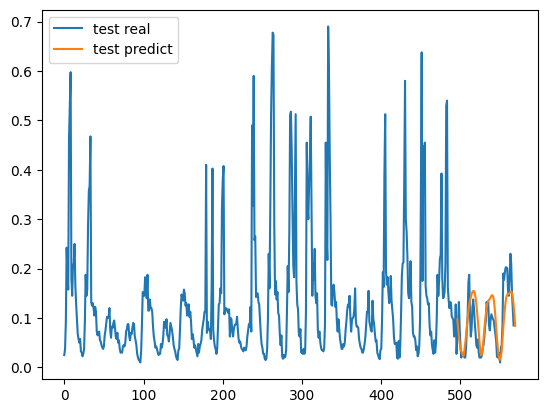

In [384]:
plt.plot(np.r_[train_y[:,-1],test_y[:,-1]], label='test real')
plt.plot(range(496,570), model.predict(test_X).flatten(), label='test predict')
plt.legend()
plt.show()

# Third Iteration: Q Post

```q
system"c 40 150";
system"l pykx.q";

.pykx.pyexec"import numpy as np";
.pykx.pyexec"from haversine import haversine_vector, Unit";


// data loading
weather:.Q.id("  II ***",(24*2)#"FS";enlist ";")0:`$":../dic_meteo22.csv";
traffic:.Q.id("IPS  J S";enlist ";")0:`$":../12-2022.csv";
weather_station:.Q.id("SISS";enlist ";")0:`$":../Estaciones_control_datos_meteorologicos.csv";
traffic_station:.Q.id("SISSSSSSS";enlist ";")0:`$":../pmed_ubicacion_12-2022.csv";

-1"loaded input data";

weather:(`ANO`MES`DIA`ESTACION`MAGNITUD!`year`month`day`weather_station`magnitude) xcol weather

// preprocess weather data
weather:`weather_station`date xcols `year`month`day _update date:"D"$(raze')flip(year;month;day) from weather;

cw:cols weather;
mc:(neg 2*24)_ cw;
tr:{(flip;enlist,cw where cw like x,"*")};

ops:(mc,`time`magnitude_value`ok)!mc,((#;(count,`i);(enlist;(*;01:00;til,24)));tr"H";tr"V");
weather:ungroup?[weather;();0b;ops];
weather:delete from weather where ok<>`V;
weather:update date:("P"$((string date),'" ",'string"t"$time))from weather;
weather:update weather_station:"j"$weather_station from weather;
weather:delete valid,time from weather;
mag:80 81 82 83 86 87 88 89!`ultraviolet`wind`direction`temperature`humidity`pressure`solar`rainfall;
weather:update mag magnitude from weather;
u:value mag;
weather:0!exec u#magnitude!magnitude_value by date,weather_station from weather;
weather:0f^weather;
-1"preprocessed weather table";

weather_station:(`CODIGO_CORTO`LONGITUD`LATITUD!`weather_station`longitude`latitude)xcol weather_station
traffic_station:(`id`longitud`latitud!`traffic_station`longitude`latitude)xcol traffic_station

-1"preprocessed weather and traffic station data";

traffic:(`fecha`id!`date`traffic_station)xcol traffic;
traffic:`date xasc select traffic_load:avg carga by date: 0D01:00:00 xbar fecha,traffic_station from traffic where error=`N
-1"preprocessed traffic data";

b:select "F"$string longitude,"F"$string latitude from weather_station;
a:select "F"$string longitude,"F"$string latitude from traffic_station;
pow2:xexp[;2];
/ distance:{[x1;x2;y1;y2;pow2]abs(pow2[x1]-pow2[y1])+abs(pow2[x2]-pow2[y2])}[;;;;pow2];
/ distance_matrix:distance[b.longitude; b.latitude]'[a.longitude; a.latitude];

.pykx.setdefault"pd";
.pykx.set[`a;`longitude`latitude#a];
.pykx.set[`b;`longitude`latitude#b];
distance_matrix:flip(.pykx.eval"haversine_vector(a, b, Unit.KILOMETERS, comb=True)")`;
-1"calculated distance matrix";

ids:distance_matrix?'min each distance_matrix;

distance_table:select "I"$string traffic_station,"F"$string weather_station:weather_station[ids][`weather_station] from traffic_station;

complete:(`traffic_station xkey traffic) lj `traffic_station xkey distance_table;
complete:0!aj[`weather_station`date;complete;weather];
complete:update hour:`hh$date,weekday:("d"$date)mod 7 from complete;
-1"built complete table. begin model prep";
/ complete:("PJFFFFFFFFFJFJJF";enlist ",")0:`$":../complete.csv";
minMaxScale:{[l]
    minL:min l;
    maxL:max l;
    ({(x-y)%(z-y)}[;minL;maxL]')l};

final:select date, traffic_station, hour, weekday, traffic_load: traffic_load%100, temperature:minMaxScale temperature, rainfall:minMaxScale rainfall 
	from complete
	where weekday>1,9<hour,hour<20, 40 <= (avg; traffic_load) fby traffic_station;

-1"preprocessed final table";

time_window:{[tt;data;lb]
    lb:lb+1;
    op:$[tt=`train;#;_];                                      / `train or `test decide the operator
    m:`rainfall`temperature`traffic_load`hour`weekday;        / the 5 columns we need
    data:?[data;();`traffic_station;m!({(y;(-;(count;x);80);x)}[;op]')m]; / first 80 or until the last 80 depending on operator 
    sw:{({y#z _x}[x;5;]')til count b:y _x}[;lb];              / sliding window function. takes turbomatrix and divides into chunks of 5x5
    gl:{y _(flip x)[2]}[;lb];                                  / gets the load (y data)
    toMatrix:{({[t;i]value t[i]}[x;]')til count x:flip x};    / table to matrix
    data:(toMatrix')data;                                     / convert each subtable (data is a keyed table) to a matrix
    X:(sw')data;                                              / apply sliding window to get X
    y:(gl')data;                                              / and gl to get y
    (X;y)                                                     / return both
    };

train:time_window[`train;final;5];

-1"train shape:";
show first train[0][3403];

test:time_window[`test;final;5];

-1"test shape:";
show first test[0][3403];

.pykx.setdefault"py";

system"l kerasmodel.p";

-1"fit model";
modelfit:.pykx.get`fit;
modelfit[train[0][3403];train[1][3403];test[0][3403];test[1][3403]];

-1"predict model";
modelpredict:.pykx.get`predict;
res:modelpredict[train[0][3403]];

-1"final result:";
show res`;
exit 1;
```

``` python
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, Conv1D

model = Sequential()
model.add(LSTM(units = 500, return_sequences=True, input_shape=[None,5]))
model.add(LSTM(units = 250,return_sequences=True))
model.add(LSTM(units = 50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(loss='mae', optimizer='adam')
model.summary()

def fit(train_X, train_y, test_X, test_y):
    model.fit(train_X, train_y, epochs=3, batch_size=64, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    return True


def predict(data):
    return model.predict(data)

```